In [1]:
#Main libs
%matplotlib inline
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#Torch libs
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
from torch.utils.data import DataLoader

# Description

__Input:__ Two datasets of sizes 1460 and 1459, respectively. Each data point in these datasets consists of 79 parameters: 39 numerical values and 40 non-numerical discrete parameters. The first dataset also includes SalePrice.

__Output:__ Predictions of SalePrice for the second dataset.

__Goal:__ Create a regression model to predict SalePrice for the second dataset with minimal error. The error is calculated using the formula:

log_rmse = $(\frac{\sum_{i=1}^N(log(y_i)-log(\hat{y}_i))^2}{N})^{1/2}$


# Data

In this section, we will preprocess data. This includes cleaning, vectorizing, normalizing, and splitting it into training and testing sets.

In [3]:
df_raw = pd.read_csv('Kaggle_house_prices/train.csv') #Data to be splitted train-test. Includes SalePrice
df_pred_raw= pd.read_csv('Kaggle_house_prices/test.csv') #Data for the results. SalePrice to be predicted.
print(df_raw.shape, df_pred_raw.shape)

(1460, 81) (1459, 80)


In [4]:
df_raw.iloc[:5]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Since SalePrice is the target value we want to predict, we save it separately and drop it along with Id.

In [5]:
target_raw = df_raw['SalePrice'] #split the target values
df_clean = df_raw.drop(columns=['Id','SalePrice']) #drop unnecessary columns
pred_id = df_pred_raw['Id'] #save prediction Id for later use
df_pred_clean = df_pred_raw.drop(columns=['Id']) #drop unnecessary columns

Next, we concatenate the training and test data to normalize them together. Normalization is a standard technique in both data science and theoretical physics, used to represent data with smaller numbers for convenience and computational efficiency. We subtract mu, a constant representing the mean, and divide by sigma, another constant representing the standard deviation. It is crucial to save mu and sigma, as they must remain constant. Whenever we apply our model to new data, we must use these same constants, not the mean and standard deviation of the new data.

In [6]:
df_conc = pd.concat([df_clean,df_pred_clean]) #concatenate all data for preprocessing
num_columns = df_conc.select_dtypes(include = ['float64', 'int64']).columns #take numerical columns
mu_df = df_conc[num_columns].mean() #save mean for further use
sigma_df = df_conc[num_columns].std() #save std dev for further use
df_conc[num_columns] = df_conc[num_columns].apply(lambda x: (x-x.mean())/(x.std())) #normalize around the mean
df_conc[num_columns] = df_conc[num_columns].fillna(0) #set NaN to 0 which is the mean of the normalized data
mu_target = target_raw.mean() #save mean for further use
sigma_target = target_raw.std() #save std dev for further use
target = (target_raw - target_raw.mean())/target_raw.std() #normalize target 

In [7]:
len(num_columns)

36

Next, we address non-numerical values by creating a new numerical dimension for each unique non-numerical value in a column. For example, the SaleCondition column has two non-numerical values: Normal and Abnorml. These are mapped to $\mathbb{R}^2$, where Normal is represented by (1,0) and Abnorml by (0,1). This process, known as one-hot encoding, can become complex and cumbersome, especially when dealing with many non-numerical values. However, in our case, we only have a few unique values across 43 non-numerical columns, and the PyTorch library simplifies this task by automating the process.

In [8]:
df_conc = pd.get_dummies(df_conc,dummy_na=True) ### vectorize non-numerical discrete values: 43 columns -> 294 columns
df_conc.shape

(2919, 330)

Preprocessing is almost done! We just need to un-concatenate the data and split it into training and testing sets.

In [9]:
#separate df and pred
df = df_conc[:1460]
df_pred = df_conc[1460:]

#split df train=1200, test=260
var = np.random.choice(range(1459), 260, replace=False) #replace = no rep.
df_train = df.drop(var)
train_target = target_raw.drop(var)
df_test = df.loc[var]
test_target = target_raw.loc[var]

In [10]:
#Transform everything to appropriate tensors for the dataloader
df_tens = torch.tensor(df.values.astype(np.float32))
df_train_tens = torch.tensor(df_train.values.astype(np.float32))
target_train_tens = torch.tensor(train_target.values.astype(np.float32)).reshape(-1,1)
df_test_tens = torch.tensor(df_test.values.astype(np.float32))
target_test_tens = torch.tensor(test_target.values.astype(np.float32)).reshape(-1,1)
df_pred_tens = torch.tensor(df_pred.values.astype(np.float32))


In [11]:
print(df_train_tens.shape, target_train_tens.shape)
print(df_test_tens.shape, target_test_tens.shape)
print(df_pred_tens.shape)
#looks good
#DATA IS READY FOR TRAINING!

torch.Size([1200, 330]) torch.Size([1200, 1])
torch.Size([260, 330]) torch.Size([260, 1])
torch.Size([1459, 330])


# Model

We use a regression model and define model as a subclass of nn.Module of Pytorch library so that we can use Pytorch functionalities for training. The choices we have to make at this point are

__depth:__ number of hidden layers (features) = 4

__hidden layer size:__ number of nodes in each hidden layer: 500, 2000, 200, 32

__activation functions:__ non-linear function to be applied at each layer: ReLU

__loss function:__ log_rmse 

Here is a summary of layers we defined:

$$\mathbb{R}^{330\times n}\xrightarrow[ReLU\circ (Linear)]{max(0,- .W_1+b_1)} \mathbb{R}^{500\times n} \rightarrow \mathbb{R}^{2000\times n}\rightarrow \mathbb{R}^{200\times n}\rightarrow \mathbb{R}^{32\times n}\rightarrow \mathbb{R}^{1\times n}$$

$$X\mapsto H_1 = max(0,W_1.X+b_1)\mapsto H_2 = max(0,W_2.H_1+b_2) \mapsto H_3\mapsto H_4 \mapsto \hat{Y}$$

In [12]:
class predicter(nn.Module): #(batch_size=n, 330) --> 1
    def __init__(self, in_size=330, H1=500,H2=2000,H3=200,H4=32,out_size=1,d_o=0):
        super(predicter, self).__init__()
        self.lp1 = nn.Linear(in_size,H1)
        self.lp2 = nn.Linear(H1,H2)
        self.lp3 = nn.Linear(H2,H3)
        self.lp4 = nn.Linear(H3,H4)
        self.lp5 = nn.Linear(H4,out_size)
        self.act = nn.ReLU()
        self.drop = nn.Dropout(d_o)

    def forward(self, X):
        X = self.drop(self.act(self.lp1(X)))
        X = self.drop(self.act(self.lp2(X)))
        X = self.drop(self.act(self.lp3(X)))
        X = self.drop(self.act(self.lp4(X)))
        X = self.drop(self.act(self.lp5(X)))
        return X

In [13]:
mse_loss = nn.MSELoss(reduction='sum')
mse_loss_mean = nn.MSELoss(reduction='mean')
def rmse(y,y_hat):
    log_rmse = torch.sqrt(mse_loss_mean(torch.log(y),torch.log(y_hat)))
    return log_rmse

# Train

Next, we have to define the training loop. The model we defined assigns random $W$ and $b$ parameters to find a number by the map $\mathbb{R}^{330\times n}\rightarrow\mathbb{R}^{1\times n}$. Then, we calculate loss, take partial derivative $g_i = \nabla_{i} (loss)$ for each layer and update parameters $(W_i,b_i)\rightarrow (W,b)-\eta. g_i$ where $\eta$ is the learning rate. Pytorch does these automatically. 

In [14]:
def train(model, data, target, optimizer, epoch, device='cpu'):
    train_loss = 0
    model.train()
    optimizer.zero_grad()
    data = data
    target = target
    data, target = data.to(device), target.to(device)
    output = model(data)
    train_loss = rmse(output, target) #mean squared error: #TODO: PROBLEM HERE!!!
    train_loss.backward() #calculates gradients
    optimizer.step() #updates weights
    trainloss.append(train_loss.detach())
    print('\nEpoch: {} Train Loss: {:.4f}\n'.format(epoch,
    train_loss))

In [15]:
def test(model, data, target, device='cpu'):
    test_loss = 0
    model.eval()
    data = data
    target = target
    data, target = data.to(device), target.to(device)
    output = model(data)
    test_loss = rmse(output, target)
    testloss.append(test_loss.detach())
    print(f" Test Loss {test_loss}")
    

__Hyperparameters:__

optimizer: updates parameters. = SGD.

learnin rate = 0.1

weight decay = None

drop out = 0

In [16]:
torch.manual_seed(4321)
model = predicter()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

trainloss = []
testloss = []
accuracy = []
for epoch in range(0,1500):
    train(model, df_train_tens, target_train_tens, optimizer, epoch+1)
    test(model, df_test_tens, target_test_tens)


Epoch: 1 Train Loss: 14.1226

 Test Loss 11.909591674804688

Epoch: 2 Train Loss: 11.8673

 Test Loss 11.763948440551758

Epoch: 3 Train Loss: 11.7218

 Test Loss 11.623167991638184

Epoch: 4 Train Loss: 11.5812

 Test Loss 11.478662490844727

Epoch: 5 Train Loss: 11.4369

 Test Loss 11.322469711303711

Epoch: 6 Train Loss: 11.2809

 Test Loss 11.147958755493164

Epoch: 7 Train Loss: 11.1068

 Test Loss 10.951188087463379

Epoch: 8 Train Loss: 10.9104

 Test Loss 10.731232643127441

Epoch: 9 Train Loss: 10.6908

 Test Loss 10.489948272705078

Epoch: 10 Train Loss: 10.4498

 Test Loss 10.232319831848145

Epoch: 11 Train Loss: 10.1925

 Test Loss 9.96566104888916

Epoch: 12 Train Loss: 9.9260

 Test Loss 9.697720527648926

Epoch: 13 Train Loss: 9.6582

 Test Loss 9.434917449951172

Epoch: 14 Train Loss: 9.3955

 Test Loss 9.181634902954102

Epoch: 15 Train Loss: 9.1423

 Test Loss 8.940415382385254

Epoch: 16 Train Loss: 8.9010

 Test Loss 8.712271690368652

Epoch: 17 Train Loss: 8.6729

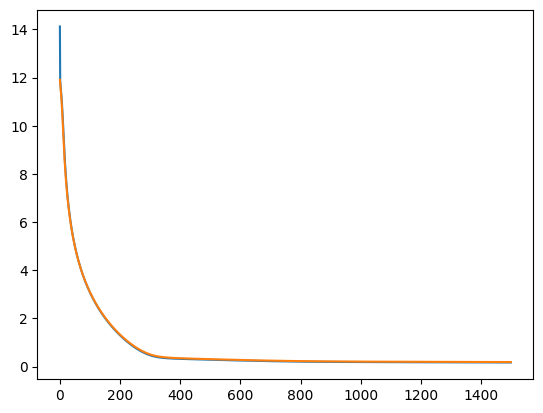

In [17]:
plt.plot(trainloss, label='train_loss')#lr 0.1, rmse
plt.plot(testloss, label='test_loss')
plt.show()

# Results

First, let's take a look at what we have learnt. The model basically learnt the following number of parameters:

In [18]:
for params in model.parameters():
    print(params.shape)

torch.Size([500, 330])
torch.Size([500])
torch.Size([2000, 500])
torch.Size([2000])
torch.Size([200, 2000])
torch.Size([200])
torch.Size([32, 200])
torch.Size([32])
torch.Size([1, 32])
torch.Size([1])


Let's calculate error and compare our predictions with the actual results of the training data.

In [19]:
y_hat = model(df_tens).detach().reshape(1460)
y = torch.tensor(target_raw)
rmse(y,y_hat) 

tensor(0.1712)

In [20]:
df_res = pd.DataFrame(y.numpy(), columns=['SalePrice'])
df_res['predictions'] = pd.DataFrame(y_hat.numpy(),columns=['predictions'])
df_res #doesn't look too bad!

,SalePrice,predictions
0,208500,224641.687500
1,181500,182967.093750
2,223500,229908.890625
3,140000,168062.656250
4,250000,269913.875000
...,...,...
1455,175000,205520.687500
1456,210000,209720.765625
1457,266500,197443.140625
1458,142125,137613.890625


Next, we calculate predictions for the test data and save it as a .csv file for submission to Kaggle.

In [21]:
predictions_raw = model(df_pred_tens).detach().reshape(1459)

In [22]:
predictions_df = pd.DataFrame(predictions_raw.numpy(), columns=['SalePrice'])
predictions_df['Id'] = pred_id
predictions_df = pd.DataFrame(predictions_df, columns=['Id', 'SalePrice'])

In [23]:
predictions_df

,Id,SalePrice
0,1461,120461.359375
1,1462,163342.218750
2,1463,200931.531250
3,1464,220835.203125
4,1465,182689.343750
...,...,...
1454,2915,84996.109375
1455,2916,98403.828125
1456,2917,198683.656250
1457,2918,112219.421875


In [24]:
predictions_df.to_csv('./submission.csv', columns=['Id', 'SalePrice'], index=False)